<a href="https://colab.research.google.com/github/Murcha1990/Raiffaizen_ML_summer2023/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_9_bagging/ML_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение: полный pipeline

Мы будем работать с датасетом про алмазы - в нем содержатся их различные характеристики, а также стоимость.

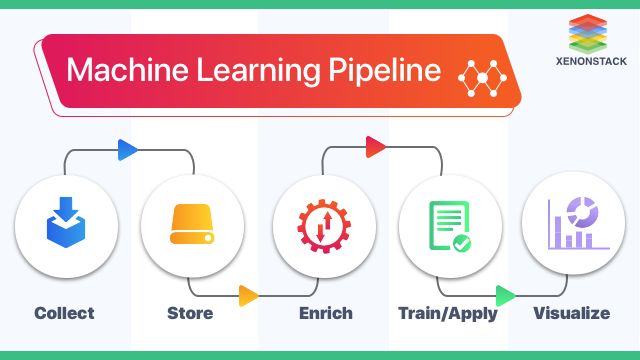

**Цели на сегодня:**

* работа с категориальными признаками

* интерпретация прогнозов моделей

* Explainer Dashboard

## Импорт библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DIAMONDS_DATASET = "https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/diamonds_clean.csv"

In [3]:
df = pd.read_csv(DIAMONDS_DATASET)

## Описание данных

* `carat` - число каратов алмаза
* `cut` - огранка алмаза
* `color` - цвет алмаза
* `clarity` - прозрачность алмаза
* `depth` - глубина алмаза
* `table` - платформа алмаза (грань, которую можно увидеть, если смотреть на камень лицевой стороной вверх)
* `price` - цена алмаза
* `x` - размер алмаза по оси x
* `y` - размер алмаза по оси y
* `z` - размер алмаза по оси z

In [4]:
df.head()

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75


## Случайное дерево

In [5]:
X = df[['carat','depth','table',"'x'","'y'","'z'"]]
y = df['price']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

In [8]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.7693200777715439

## Решающий лес

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

In [10]:
r2_score(y_test, pred_rf)

0.8739134262781276

## Подбор гиперпараметров по сетке

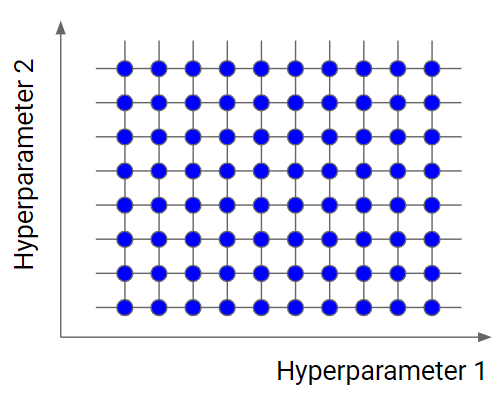

In [15]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

params = {'n_estimators' : np.arange(5, 100, 5),
          'min_samples_leaf' : np.arange(1, 15, 3)
         }

gs = GridSearchCV(model, params, scoring='r2', cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 95 candidates, totalling 285 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': array([ 1,  4,  7, 10, 13]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
             scoring='r2', verbose=2)

In [16]:
gs.best_score_, gs.best_params_

(0.8856575113793191, {'min_samples_leaf': 13, 'n_estimators': 85})

In [17]:
pred = gs.best_estimator_.predict(X_test)

r2_score(y_test, pred)

0.878604659387788

## Учет категориальных признаков

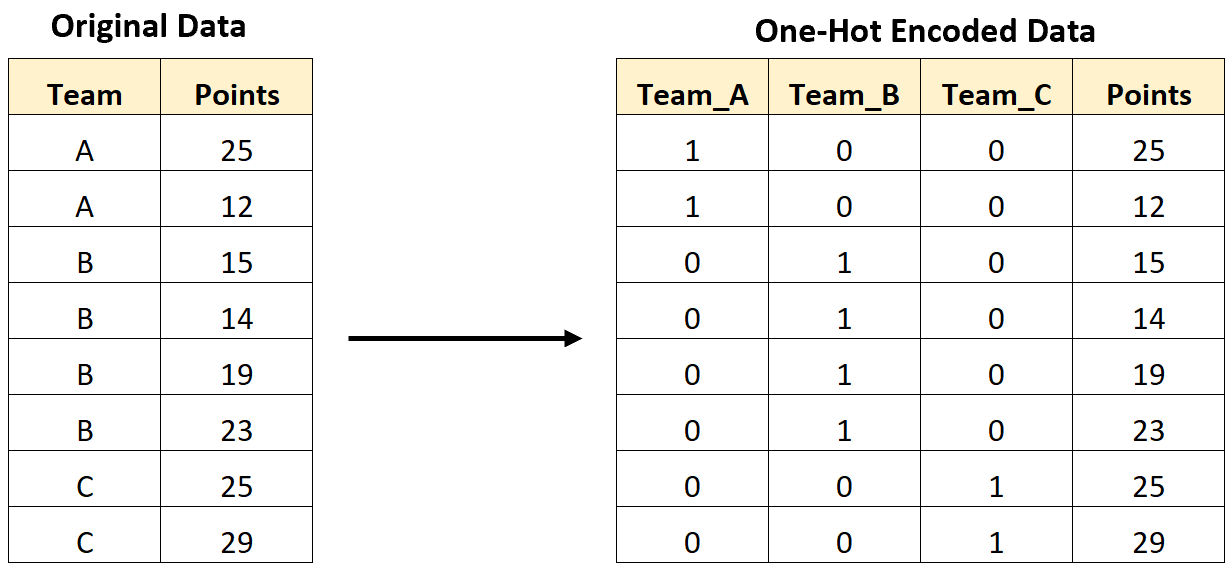

In [18]:
X_full = df.drop('price', axis=1)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [19]:
X_train_full.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
'x'        float64
'y'        float64
'z'        float64
dtype: object

In [20]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

categorical = ['cut', 'color', 'clarity']
numeric_features = ['carat', 'depth', 'table', "'x'", "'y'", "'z'"]

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', MinMaxScaler(), numeric_features)
])

X_train_transformed = ct.fit_transform(X_train_full)
X_test_transformed = ct.transform(X_test_full)

In [21]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['cut_Fair',
 'cut_Good',
 'cut_Ideal',
 'cut_Premium',
 'cut_Very Good',
 'color_D',
 'color_E',
 'color_F',
 'color_G',
 'color_H',
 'color_I',
 'color_J',
 'clarity_I1',
 'clarity_IF',
 'clarity_SI1',
 'clarity_SI2',
 'clarity_VS1',
 'clarity_VS2',
 'clarity_VVS1',
 'clarity_VVS2',
 'carat',
 'depth',
 'table',
 "'x'",
 "'y'",
 "'z'"]

In [22]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,...,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,carat,depth,table,'x','y','z'
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.110187,0.461111,0.235294,0.548417,0.099321,0.110063
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.047817,0.530556,0.215686,0.447858,0.082343,0.094340
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.037422,0.522222,0.190196,0.434823,0.079626,0.091195
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.168399,0.488889,0.294118,0.607076,0.110187,0.123899
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.270270,0.550000,0.254902,0.667598,0.122750,0.142138


In [24]:
model = RandomForestRegressor()

model.fit(X_train_transformed, y_train_full)

RandomForestRegressor()

In [26]:
pred = model.predict(X_test_transformed)

r2_score(y_test_full, pred)

0.978067462154695

## Pipeline

In [ ]:
# ohe = OneHotEncoder()

# ohe.fit(X_train)

# X_train = ohe.transform(X_train)
# X_test = ohe.transform(X_test)

# sc = MinMaxScaler()

# sc.fit(X_train)

# X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)

# model = KNN()

# model.fit(X_train)
# pred = model.predict(X_test)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([
    ('transformer', ct), # преобразование данных
    ('model', RandomForestRegressor()) # обучение модели
    ])

pipe.fit(X_train_full, y_train_full)

pred_pipe = pipe.predict(X_test_full)

In [28]:
r2_score(y_test_full, pred_pipe)

0.9781844164497648

Подбор гиперпараметров в пайплайне

In [29]:
params = {'model__n_estimators' : [50, 100, 150, 200]}

gs = GridSearchCV(pipe, params, scoring='r2', cv=3, n_jobs=-1, verbose=2)
gs.fit(X_train_full, y_train_full)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['cut',
                                                                          'color',
                                                                          'clarity']),
                                                                        ('scaling',
                                                                         MinMaxScaler(),
                                                                         ['carat',
                                                                          'depth',
                                                                          'table',
                                                                          "'x'",
                                                                          "'y'",
                                                                          "'z'"])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1, param_grid={'model__n_estimators': [50, 100, 150, 200]},
             scoring='r2', verbose=2)

In [36]:
gs.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cut', 'color', 'clarity']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['carat', 'depth', 'table',
                                                   "'x'", "'y'", "'z'"])])),
                ('model', RandomForestRegressor(n_estimators=200))])

## Интерпретация признаков

In [31]:
!pip install eli5 -q
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 10.5 MB/s eta 0:00:00


In [32]:
import eli5 # permutation importance
import shap # shapley

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Permutation Importance

Для оценки важности признаков, мы:

сначала обучим модель на всех признаках
вычислим целевую метрику качества (с ней потом будем сравнивать)
Чтобы оценить, например, важность признака *Height at age 10*:

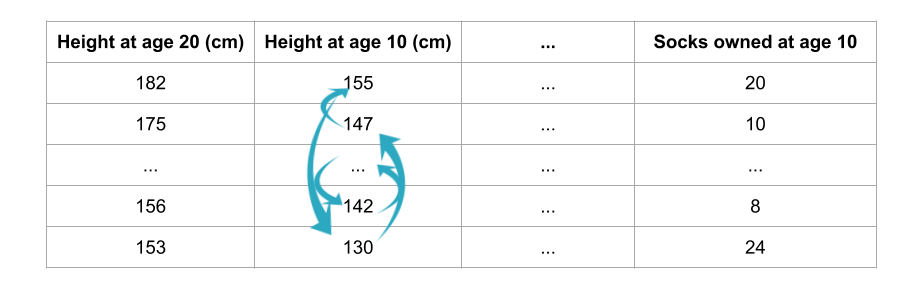

*  случайным образом перемешаем его значения
*  вычислим прогноз модели (уже обученной) на обновленном наборе признаков (с перемешанным признаком)
*  вычислим изменение целевой метрики по сравнению с исходным значением

Если признак важен для модели, то при случайном перемешивании значение метрики качества упадет. Чем больше это падение - тем более важен признак.

Для того, чтобы получить более стабильную оценку важности, перемешивание делается несколько раз и изменение целевой метрики усредняется.

In [33]:
X_train_transformed.shape

(40353, 26)

In [39]:
perm = eli5.sklearn.PermutationImportance(rf, random_state=42).\
    fit(X_train.iloc[:1000], y_train.iloc[:1000])

eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
1.0434 ± 0.0525,'y'
0.3015 ± 0.0361,carat
0.1357 ± 0.0059,'x'
0.0765 ± 0.0066,'z'
0.0592 ± 0.0076,table
0.0592 ± 0.0045,depth


### Shapley values

Процесс вычисления Shapley Values включает следующие шаги:

*  *Определение коалиции*: коалиция представляет собой подмножество признаков. Пустое подмножество (без признаков) и полное множество (со всеми признаками) также рассматриваются.

*  *Вычисление вклада*: для каждой коалиции вычисляется вклад каждого признака в предсказание модели. Это делается путем сравнения предсказания модели с добавленным признаком и без него.

*  *Суммирование вкладов*: все вклады суммируются по различным коалициям, учитывая их вероятность появления. Вероятность каждой коалиции вычисляется на основе количества перестановок признаков.

*   *Нормализация*: итоговые Shapley Values нормализуются для обеспечения свойства справедливости (additivity) и учета общей предсказательной способности модели.

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Census%20income%20classification%20with%20scikit-learn.html

In [40]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer(X_test.iloc[:1000,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


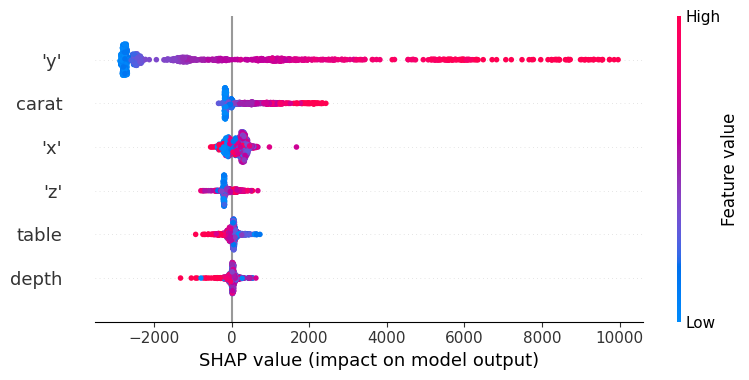

In [41]:
shap.summary_plot(shap_values, X_test.iloc[:1000])

## Explainer Dashboard

[tutorial](https://github.com/oegedijk/explainerdashboard/blob/c7c515c05c5a161226193e40a8258c310fc7901d/notebooks/dashboard_examples.ipynb)

In [11]:
!pip install explainerdashboard -q

In [12]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
explainer = RegressionExplainer(rf, X_test.iloc[:10], y_test.iloc[:10])

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [15]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [16]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)


<IPython.core.display.Javascript object>

Dash app running on:


<IPython.core.display.Javascript object>

### Примеры дашбордов

https://titanicexplainer.herokuapp.com